# Prompt

FINAL PROJECT Due Nov. 30 at 1:00pm

On a text document of your choice (in a natural language of your choice) run the graph-based NLP program at http://www.cse.unt.edu/~tarau/teaching/AI/stanza_nlp.py to extract a summary and keywords.

Compare its results with the summary and keywords you would have extracted manually from the document.

Replace the simple 2-layer neural network at: http://www.cse.unt.edu/~tarau/teaching/AI/nlp_nn.py that uses the dataset of dependency edges generated on your document, with a deep neural network of your choice (LSTM, GNN, etc.) and compare its information retrieval performance with the algorithmically and neurally derived answers generated by nlp_nn.py, on a set of 10 questions.

# Installs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install stanza

# Imports

In [ ]:
# For stanza_nlp.
from graphviz import Digraph as DotGraph
import stanza
import csv
import os
import networkx as nx
import pickle
from pathlib import Path

# For nlp_nn that was not imported in stanza_nlp.
import csv
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from collections import defaultdict, Counter
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

from pathlib import Path
import tensorflow as tf

# Global Variables

In [ ]:
# Data and output directories.
working_file = "lstm_intro"
root_dir = ""
raw_dir = root_dir+"texts/"
out_dir = root_dir+"out/"+working_file+"/"

# Model variables.
MAX_EDGES = 900     # Maximum number of edges in a graph.

# Part One - stanza_nlp.py

On a text document of your choice (in a natural language of your choice) run the graph-based NLP program at http://www.cse.unt.edu/~tarau/teaching/AI/stanza_nlp.py to extract a summary and keywords.

Compare its results with the summary and keywords you would have extracted manually from the document.

## Functions

In [ ]:
# Generator for all node-node-label tuples of edges within graph.
def gen_dot_edges(g, attr=None):
    for e in g.edges():
        f, t = e
        if not attr: 
            w = ""
        else:
            w = g[f][t].get(attr)
        if not w: 
            w = ""
        if not isinstance(f, str): 
            f = "#" + str(f)
        if not isinstance(t, str): 
            t = "#" + str(t)
        f = f.replace(":", ".")
        t = t.replace(":", ".")
        w = str(w)
        yield (f, t, w)

# Shows a network digraph.
def gshow(g, attr=None, file_name="out/temp.gv", view=False):
    ecount = g.number_of_edges()
    if ecount > MAX_EDGES:
        print("GRAPH TOO BIG TO SHOW, EDGES=", ecount)
        return
    dot = DotGraph()
    for e in gen_dot_edges(g, attr=attr):
        f, t, w = e
        dot.edge(f, t, label=w)
    dot.render(file_name, view=view)

# Get string from file.
def file2text(fname):
    with open(fname, "r") as f:
        return f.read()

# Converts edges into a digraph.
def facts2nx(fgen):
    g = nx.DiGraph()
    for f, rel, t, id in fgen:
        g.add_edge(f, t)
    return g

# Uses rank dictionary to extract keywords and salient sentences.
def ranks2info(ranks, keyns, wk, sk):
    ranked = sorted(ranks.items(), key=(lambda x: x[1]), reverse=True)
    sids = []
    kwds = []
    for x, r in ranked:
        if wk<=0: 
            break
        if isinstance(x, str) and x in keyns:
            kwds.append(x)
            wk -= 1
    for x, r in ranked:
        if sk <= 0: 
            break
        if isinstance(x, int):
            sids.append(x)
            sk -= 1
    return kwds, sids

# Writes out edge facts as .tsv file.
def facts2tsv(fgen, fname):
    ensure_path(fname)
    with open(fname, "w", newline="") as f:
        writer = csv.writer(f, delimiter="\t")
        for fact in fgen:
            writer.writerow(fact)

# Writes out edge facts as Prolog file.
def facts2prolog(fgen, fname):
    ensure_path(fname)
    with open(fname, "w") as f:
        for fact in fgen:
            print("edge", end="",file=f)
            print(fact, end=".\n", file=f)

# Check if file or directory exists.
def exists_file(fname):
    return os.path.exists(fname)

# Get home directory as string.
def home_dir():
    return str(Path.home())

# Make directory if it doesn't exist.
def ensure_path(fname):
    dir, _ = os.path.split(fname)
    os.makedirs(dir, exist_ok=True)

# Run nlp pipeline from a text file to extract information and generate graphs.
def run_pipeline(fname="english", idir="texts/", odir="out/english/", lang="en", kws=8):   # Formerly test().
    nlp=NLP(lang)
    nlp.from_file(fname, idir, odir)
    nlp.to_tsv()
    nlp.to_prolog()
    nlp.summarize(wk=kws)
    nlp.show()

## Classes

In [ ]:
# Information extraction from a file.
class NLP:
    # Stanza-based multi-lingual NLP processor that extracts summaries and keywords
    # and builds text graph edge files derived from dependency links usable donwstream
    # for algorithmic and deep-learning based information retrieval tasks.
    
    # Init, load stanza.
    def __init__(self, lang="en"):
        if not exists_file(home_dir()+"/stanza_resources/"+lang):
            stanza.download(lang)
        self.nlp = stanza.Pipeline(lang=lang, logging_level="WARN")

  # Process text from a file.
    def from_file(self, fname="english", input_loc="texts/", output_loc="out/english/"):
        self.fname = fname
        self.in_loc = input_loc
        self.out_loc = output_loc
        text = file2text(input_loc + fname + ".txt")
        self.doc = self.nlp(text)

    # Generate stanza output on text.
    def from_text(self, text="Hello!"):
        self.doc = self.nlp(text)

    # Decide if a noun is a key noun.
    def keynoun(self, x):
        return x.upos == "NOUN" and ("subj" in x.deprel or "ob" in x.deprel)

    # Generator to get from-link-to-sentence_id tuples.
    def facts(self):

        def fact(x, sent, sid):
            if x.head == 0:
                yield x.lemma, x.upos+"_PREDICATE_OF", sid, sid
            else:
                hw = sent.words[x.head-1]
                if self.keynoun(x): # Reverse link to prioritize key nouns.
                    yield hw.lemma, hw.upos + "rev_" + x.deprel + x.upos, x.lemma, sid
                    yield (sid, "ABOUT", x.lemma, sid)
                else:
                    yield x.lemma, x.upos + x.deprel + hw.upos, hw.lemma, sid
                if  x.deprel in ("compound", "flat") :
                    comp = x.lemma + " " + hw.lemma
                    yield x.lemma, x.upos + "inCOMPOUND", comp, sid
                    yield hw.lemma, hw.upos + "inCOMPOUND", comp, sid
                    yield (sid, "ABOUT", comp, sid)

        for sid, sent in enumerate(self.doc.sentences):
            for x in sent.words :
                yield from fact(x, sent, sid)

    # Get key nouns.
    def keynouns(self):
        ns = set()
        for sent in self.doc.sentences:
            for x in sent.words:
                if self.keynoun(x):
                    ns.add(x.lemma)
        return ns

    # Converts info to graph.
    def to_nx(self): 
        return facts2nx(self.facts())

    # Get sentence from text by id.
    def get_sent(self, sid) :
        return self.doc.sentences[sid].text

    # Extract keywords and summary sentences.
    def info(self, wk=8, sk=6):
        g = self.to_nx()
        ranks = nx.pagerank(g)
        ns = self.keynouns()
        kwds, sids = ranks2info(ranks, ns, wk, sk)
        sents = list(map(self.get_sent, sorted(sids)))
        return kwds, sents

    # Visual graph for k most important nodes and edges.
    def show(self, k=20):
        g = self.to_nx()
        gshow(g, file_name=self.out_loc + "pics/" + self.fname + ".gv")

    # Writes edges to .tsv file.
    def to_tsv(self):
        facts2tsv(self.facts(), self.out_loc + self.fname + ".tsv")
        self.to_sents()

    # Writes out edges to Prolog file.
    def to_prolog(self): 
        facts2prolog(self.facts(), self.out_loc + self.fname + ".pro")

  # Writes out sentences.
    def to_sents(self):

        def sent_gen():
            for sid, sent in enumerate(self.doc.sentences):
                yield sid, sent.text

        facts2tsv(sent_gen(), self.out_loc + self.fname + "_sents.tsv")

    # Extract summary and kewords from text.
    def summarize(self, wk=8, sk=5):
        kws, sents = self.info(wk, sk)
        print("\nSUMMARY:")
        for sent in sents: 
            print(sent)
        print("\nKEYWORDS:")
        for w in kws: 
            print(w, end="; ")
        print("\n")
        with open(self.out_loc + self.fname + "_keywords.pickle", "wb") as f:
            pickle.dump(kws, f)
        with open(self.out_loc + self.fname + "_summary.pickle", "wb") as f:
            pickle.dump(sents, f)

## Script

In [ ]:
# Ensure directories exist.
Path(out_dir).mkdir(parents=True, exist_ok=True)
Path(out_dir + "pics/").mkdir(parents=True, exist_ok=True)
Path(out_dir + "checkpoints/").mkdir(parents=True, exist_ok=True)
Path(out_dir + "checkpoints/nn/").mkdir(parents=True, exist_ok=True)
Path(out_dir + "checkpoints/gru/").mkdir(parents=True, exist_ok=True)

manual = None   # Y-axis
with open(raw_dir+working_file+"_manual_kws.txt") as f:
    manual = f.read()
    manual = manual.split("\n")
    manual = [x.strip() for x in manual]
num_kws = len(manual)

# Run nlp pipeline on text file.
run_pipeline(fname=working_file, idir=raw_dir, odir=out_dir, lang="en", kws=num_kws)

# Compare to manually extracted keywords.
print("Keyword Comparison ======================================================\n")
network = None  # X-axis
with open(out_dir+working_file+"_keywords.pickle", "rb") as f:
    network = pickle.load(f)

manual_c = []
manual_u = []
network_n = []
for i, m in enumerate(manual):
    if m in network:
        manual_c.append(m)
    else:
        manual_u.append(m)
for i, n in enumerate(network):
    if n not in manual:
        network_n.append(n)

if len(manual_c) > 0:
    print("The gold values that the network caught are:", manual_c)
if len(manual_u) > 0:
    print("The gold values that the network didn't catch are:", manual_u)
print("The network caught %d out of %d gold values.\n"%(len(manual_c), len(manual)))

if len(network_n) > 0:
    print("The network-retrieved values that were not gold keywords are:", network_n)
    print("The network found %d values that were not gold keywords."%len(network_n))

# Comparison using jaccard index.
print ("\nJaccard index:", len(manual_c)/(len(manual)+len(network)-len(manual_c)))

# Compare to manually generated summary.
print("\nSummary Comparison ======================================================\n")
manual = None   # Y-axis
with open(raw_dir+working_file+"_manual_summary.txt") as f:
    print("Manual:\n")
    print(f.read())

network = None  # X-axis
with open(out_dir+working_file+"_summary.pickle", "rb") as f:
    network = pickle.load(f)
    print("\nNetwork:\n")
    for s in network:
        print(s)


SUMMARY:
A surprising example of the power of DNNs is their ability to N-bit numbers using only 2 hidden layers of quadratic size [27].
It is a significant limitation, important problems are best expressed with sequences whose lengths are not known example, speech recognition and machine translation are sequential problems.
It is therefore clear that a domain-independent learns to map sequences to sequences would be useful.
This is by far the best result achieved by direct translation with large neural networks.
We were able to do well on long sentences because the order of words in the source sentence but not the target sentences in the training and By doing so, we introduced many short term dependencies that made the optimization simpler (see sec. 2 and 3.3).

KEYWORDS:
sentence; sequence; recognition; translation; architecture; problem; lstm; result; number; score; word; 

GRAPH TOO BIG TO SHOW, EDGES= 1154
Keyword Comparison ======================================================



# Part Two - nlp_nn.py

Replace the simple 2-layer neural network at: http://www.cse.unt.edu/~tarau/teaching/AI/nlp_nn.py that uses the dataset of dependency edges generated on your document, with a deep neural network of your choice (LSTM, GNN, etc.) and compare its information retrieval performance with the algorithmically and neurally derived answers generated by nlp_nn.py, on a set of 10 questions.

## Functions

In [ ]:
# Turns .tsv file into matrix.
def tsv2mat(fname):
    with open(fname) as f:
        wss = csv.reader(f, delimiter="\t")
        return list(wss)

# Creates .pdf line graph of metric progression.
def plot_graphs(fname, out_dir, history, metric):
    plt.plot(history.history[metric])
    #plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_" + metric])
    plt.savefig(out_dir + "pics/" + fname + ".pdf", format="pdf", bbox_inches="tight")
    plt.show()
    plt.close()

def answer_questions(fname, odir, questions):
    print("Neural Network: ========================================================")
    t_nn = Trainer_NN(fname, odir, 100, 128)
    i_nn = Inferencer(fname, odir, "_nn")
    print("\n\nGRU: ===================================================================")
    t_gru = Trainer_GRU(fname, odir, 20, 128)
    i_gru = Inferencer(fname, out_dir, "_gru")
    print("\n\nQUESTIONS: =============================================================\n")
    avg_ji = 0
    for q in questions:
        print(q+"---------------------------------------------------------------\n")
        print("NN Answer:")
        ans_sents_nn = i_nn.query(q)
        keys_nn = list(ans_sents_nn.keys())
        print("GRU Answer:")
        ans_sents_gru = i_gru.query(q)
        keys_gru = list(ans_sents_gru.keys())
        common = [x for x in keys_nn if x in keys_gru]
        ji = len(common)/(len(keys_gru) + len(keys_nn) - len(common))
        avg_ji += ji
        print("\nJaccard Index:", ji)
        print("\n\n")
    print("Average Jaccard Index:", avg_ji/len(questions))

## Classes

In [ ]:
# Holds data for question-answering problem.
class Data:
    # Builds dataset from dependency edges in .tsv file associating from-link-to 
    # edges and sentences in which they occur; links are of the form POS_deprelPOS 
    # with POS and deprel tags concatenated.

    # Init, load data from file and convert to one-hot encoding.
    def __init__(self, fname="english", odir="out/texts/"):
        wss = tsv2mat(odir + fname + ".tsv")
        self.sents = tsv2mat(odir + fname + "_sents.tsv")
        occs = defaultdict(set)
        sids = set()
        for f, r, t, id in wss:
            id = int(id)
            occs[(f, r, t)].add(id)
            sids.add(id)
        self.occs = occs # dict where edges occur

        X, Y=list(zip(*list(occs.items())))
        X = np.array(X)
        y0 = np.array(sorted(map(lambda x: [x], sids)))

        # make OneHot encoders for X and y
        enc_X = OneHotEncoder(handle_unknown="ignore")
        enc_y = OneHotEncoder(handle_unknown="ignore")
        enc_X.fit(X)
        enc_y.fit(y0)
        hot_X = enc_X.transform(X).toarray()
        self.enc_X = enc_X
        self.enc_y = enc_y
        self.X = X
        # Encode y as logical_or of sentence encodings it occurs in.
        ms = []
        for ys in Y:
            m = np.array([[0]], dtype=np.float32)
            for v in ys :
                m0 = enc_y.transform(np.array([[v]])).toarray()
                m = np.logical_or(m, m0)
                m = np.array(np.logical_or(m, m0), dtype=np.float32)
            ms.append(m[0])
        hot_y = np.array(ms)

        self.hot_X = hot_X
        self.hot_y = hot_y

        print("\nFINAL DTATA SHAPES", "X", hot_X.shape, "y", hot_y.shape, "\n")

# Queries data and gets most relative sentences.
class Query(Data):
    # Builds from-link-to dependency links form a given text query and matches it 
    # against data to retrive sentences in which most of those edges occur.

    # Init, load nlp pipeline.
    def __init__(self, fname="english", odir="out/texts/"):
        super().__init__(fname=fname, odir=odir)
        self.nlp_engine = NLP()

    # Get answers from file.
    def ask(self, text=None):
        if not text: 
            text = input("Query:")
        else: 
            print("Query:", text)
        self.nlp_engine.from_text(text)
        sids = []
        for f, r, t, _ in self.nlp_engine.facts():
            sids.extend(self.occs.get((f, r, t), []))
        self.show_answers(sids)

    # Get k most relative answers.
    def show_answers(self, sids, k=3):
        c = Counter(sids)
        print("\nHIT COUNTS:", c, "\n")
        best = c.most_common(k)
        self.ans_sents = {}
        for sid, _ in best:
            id, sent = self.sents[sid]
            print(id,":", sent)
            self.ans_sents.update({id: sent})
        print("")

# Uses trained model to answer question.
class Inferencer(Query):
    # Loads model trained on associating dependency edges to sentences in which 
    # they occur.
  
    # Init, load model.
    def __init__(self, fname="english", odir="out/texts/", extension=""):
        super().__init__(fname=fname, odir=odir)
        self.model = load_model(odir + "models/" + fname + "_model" + extension)

    # Get answer to a question.
    def query(self, text=None):
        if not text: 
            text = input("Query:")
        else: print("Query:", text)
        self.nlp_engine.from_text(text)
        X = []
        for f, r, t, _ in self.nlp_engine.facts():
            X.append([f, r, t])
        X = np.array(X)
        hot_X = self.enc_X.transform(X).toarray()
        y = self.model.predict(hot_X)
        m = self.enc_y.inverse_transform(np.nan_to_num(y))
        sids = m.flatten().tolist()
        self.show_answers(sids)
        return self.ans_sents

# 2-Layer dense network to train for question answering.
class Trainer_NN(Data):
  def __init__(self, fname="texts/english", odir="out/texts/", epochs=100, batch_size=16):
    super().__init__(fname=fname, odir=odir)

    ckpts = os.listdir(odir + "checkpoints/nn/")
    if len(ckpts) > 0:
        model = keras.models.load_model(odir + "checkpoints/nn/" + ckpts[-1])
        print("Model Found: Starting from epoch %d."%len(ckpts))
    else:
        model = keras.Sequential([layers.Dense(128, input_dim=self.hot_X.shape[1], activation="relu"), 
                                layers.Dense(self.hot_y.shape[1], activation="sigmoid")
                                ])
        model.summary()
        model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    if len(ckpts) < epochs:
        checkpoint = keras.callbacks.ModelCheckpoint(odir + "checkpoints/nn/" + "ckpt_nn_{epoch:02d}.hdf5", monitor="acc", verbose=1)
        history = model.fit(self.hot_X, self.hot_y, epochs=epochs-len(ckpts), batch_size=batch_size, callbacks=[checkpoint])

        model.save(odir + "models/" + fname + "_model_nn")

        # visualize and inform about accuracy and loss
        plot_graphs(fname + "_loss", odir, history, "loss")
        plot_graphs(fname + "_acc", odir, history, "accuracy")
    else:
        print("Maximum Checkpoints: No Training")

    loss, accuracy = model.evaluate(self.hot_X, self.hot_y)
    print("Accuracy:", round(100 * accuracy, 2), ", % Loss:", round(100 * loss, 2), "%")

# Deep GRU network to train for question answering.
class Trainer_GRU(Data):
  def __init__(self, fname="texts/english", odir="out/texts/", epochs=100, b_size=16):
    super().__init__(fname=fname, odir=odir)

    ckpts = os.listdir(odir + "checkpoints/gru/")
    if len(ckpts) > 0:
        model = keras.models.load_model(odir + "checkpoints/gru/" + ckpts[-1])
        print("Model Found: Starting from epoch %d."%len(ckpts))
    else:
        model = keras.Sequential([layers.Embedding(input_dim=1000, output_dim=self.hot_X.shape[1]), 
                                layers.GRU(256, activation="relu", dropout=0.2, recurrent_dropout=0.1, return_sequences=True), 
                                layers.GRU(124, activation="relu", dropout=0.2, recurrent_dropout=0.1), 
                                layers.Dense(64, activation="relu"), 
                                layers.Dense(self.hot_y.shape[1], activation="sigmoid")
                                ])
        model.build()
        model.summary()
        model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    if len(ckpts) < epochs:
        checkpoint = keras.callbacks.ModelCheckpoint(odir + "checkpoints/gru/" + "ckpt_gru_{epoch:02d}.hdf5", monitor="acc", verbose=1)
        history = model.fit(tf.convert_to_tensor(self.hot_X), self.hot_y, epochs=epochs-len(ckpts), batch_size=b_size, callbacks=[checkpoint])

        model.save(odir + "models/" + fname + "_model_gru")

        # visualize and inform about accuracy and loss
        plot_graphs(fname + "_loss", odir, history, "loss")
        plot_graphs(fname + "_acc", odir, history, "accuracy")
    else:
        print("Maximum Checkpoints: No Training")

    loss, accuracy = model.evaluate(self.hot_X, self.hot_y)
    print("Accuracy:", round(100 * accuracy, 2), ", % Loss:", round(100 * loss, 2), "%")

## Script

Neural Network: ========================================================

FINAL DTATA SHAPES X (1164, 764) y (1164, 41) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               97920     
_________________________________________________________________
dense_3 (Dense)              (None, 41)                5289      
Total params: 103,209
Trainable params: 103,209
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
 1/10 [==>...........................] - ETA: 0s - loss: 3.9726 - accuracy: 0.0078
Epoch 00001: saving model to out/lstm_intro/checkpoints/nn/ckpt_nn_01.hdf5
10/10 [==============================] - 0s 4ms/step - loss: 4.0561 - accuracy: 0.0344
Epoch 2/100
 1/10 [==>...........................] - ETA: 0s - loss: 4.0045 - accuracy: 0.0938
Epoch 00002: saving model to out/lst

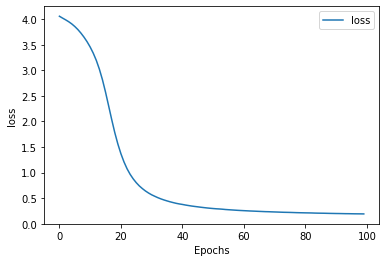

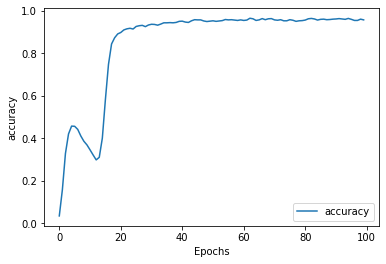

37/37 [==============================] - 0s 1ms/step - loss: 0.1902 - accuracy: 0.9562
Accuracy: 95.62 , % Loss: 19.02 %

FINAL DTATA SHAPES X (1164, 764) y (1164, 41) 



GRU: ===================================================================

FINAL DTATA SHAPES X (1164, 764) y (1164, 41) 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 764)         764000    
_________________________________________________________________
gru (GRU)                    (None, None, 256)         784896    
_________________________________________________________________
gru_1 (GRU)                  (None, 124)               142104    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8000      
_________________________________________________________________
dense_5 (Dense)         

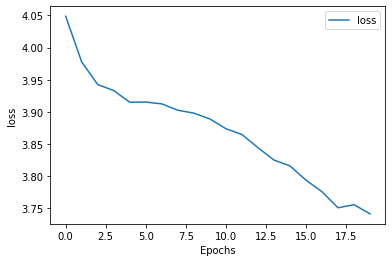

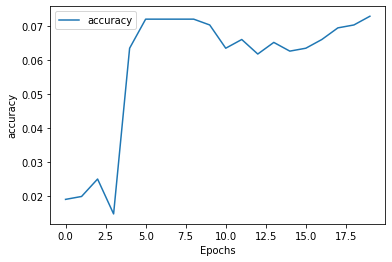

37/37 [==============================] - 55s 1s/step - loss: 3.7274 - accuracy: 0.0730
Accuracy: 7.3 , % Loss: 372.74 %

FINAL DTATA SHAPES X (1164, 764) y (1164, 41) 



QUESTIONS: =============================================================

Why is the LSTM a good choice for language modeling?---------------------------------------------------------------

NN Answer:
Query: Why is the LSTM a good choice for language modeling?

HIT COUNTS: Counter({14: 6, 0: 3, 13: 2, 38: 1, 30: 1, 21: 1, 11: 1}) 

14 : The LSTM’s ability to on data with long range temporal dependencies makes it a natural choice for this to the considerable time lag between the inputs and their corresponding outputs (fig.
0 : Deep Neural Networks (DNNs) are extremely powerful machine learning models that achieve excellent performance on difficult problems such as speech recognition [13, 7] and visual object recognition [19, 6, 21, 20].
13 : The second LSTM is essentially a recurrent neural network language 23, 30] ex

In [ ]:
questions = None
with open(raw_dir + working_file + "_questions.txt") as f:
    questions = f.read()
    questions = questions.split("\n")
    questions = [x.strip() for x in questions]

answer_questions(working_file, out_dir, questions)

Neural Network: ========================================================

FINAL DTATA SHAPES X (1164, 764) y (1164, 41) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               97920     
_________________________________________________________________
dense_3 (Dense)              (None, 41)                5289      
Total params: 103,209
Trainable params: 103,209
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
 1/10 [==>...........................] - ETA: 0s - loss: 3.9726 - accuracy: 0.0078
Epoch 00001: saving model to out/lstm_intro/checkpoints/nn/ckpt_nn_01.hdf5
10/10 [==============================] - 0s 4ms/step - loss: 4.0561 - accuracy: 0.0344
Epoch 2/100
 1/10 [==>...........................] - ETA: 0s - loss: 4.0045 - accuracy: 0.0938
Epoch 00002: saving model to out/lst

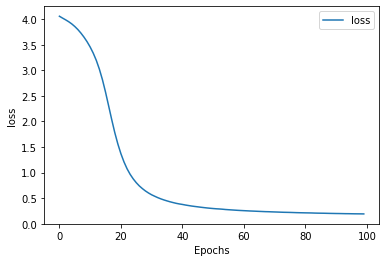

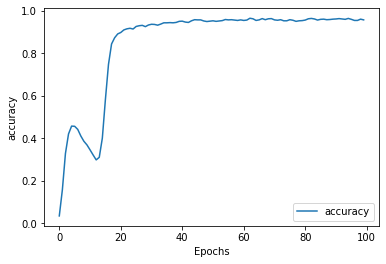

37/37 [==============================] - 0s 1ms/step - loss: 0.1902 - accuracy: 0.9562
Accuracy: 95.62 , % Loss: 19.02 %

FINAL DTATA SHAPES X (1164, 764) y (1164, 41) 



GRU: ===================================================================

FINAL DTATA SHAPES X (1164, 764) y (1164, 41) 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 764)         764000    
_________________________________________________________________
gru (GRU)                    (None, None, 256)         784896    
_________________________________________________________________
gru_1 (GRU)                  (None, 124)               142104    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8000      
_________________________________________________________________
dense_5 (Dense)         

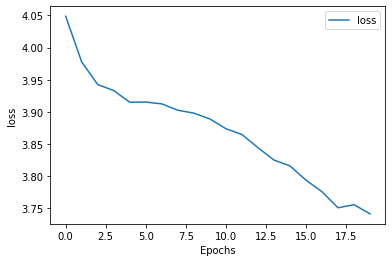

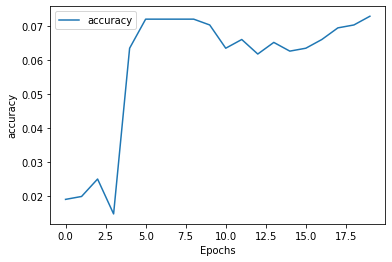

37/37 [==============================] - 55s 1s/step - loss: 3.7274 - accuracy: 0.0730
Accuracy: 7.3 , % Loss: 372.74 %

FINAL DTATA SHAPES X (1164, 764) y (1164, 41) 



QUESTIONS: =============================================================

Why is the LSTM a good choice for language modeling?---------------------------------------------------------------

NN Answer:
Query: Why is the LSTM a good choice for language modeling?

HIT COUNTS: Counter({14: 6, 0: 3, 13: 2, 38: 1, 30: 1, 21: 1, 11: 1}) 

14 : The LSTM’s ability to on data with long range temporal dependencies makes it a natural choice for this to the considerable time lag between the inputs and their corresponding outputs (fig.
0 : Deep Neural Networks (DNNs) are extremely powerful machine learning models that achieve excellent performance on difficult problems such as speech recognition [13, 7] and visual object recognition [19, 6, 21, 20].
13 : The second LSTM is essentially a recurrent neural network language 23, 30] ex

In [ ]:
questions = None
with open(raw_dir + working_file + "_questions.txt") as f:
    questions = f.read()
    questions = questions.split("\n")
    questions = [x.strip() for x in questions]

answer_questions(working_file, out_dir, questions)